In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
from category_encoders import TargetEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from catboost import CatBoostClassifier, Pool
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chocolate-rating-prediction-ai-edu/chocolate_train.csv
/kaggle/input/chocolate-rating-prediction-ai-edu/choco_sample_submission.csv
/kaggle/input/chocolate-rating-prediction-ai-edu/chocolate_test_new.csv


Никнейм в kagle: Максим Архипов

In [2]:
df = pd.read_csv('/kaggle/input/chocolate-rating-prediction-ai-edu/chocolate_train.csv')
df_test = pd.read_csv('/kaggle/input/chocolate-rating-prediction-ai-edu/chocolate_test_new.csv')

In [3]:
df.head(2)

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,Willie's Cacao,Rio Caribe,457,2009,72%,U.K.,3.25,Trinitario,Venezuela
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,72%,Switzerland,3.50,,Venezuela


In [4]:
df['Cocoa Percent'] = df['Cocoa Percent'].apply(lambda x: x[0:-1])
df['Cocoa Percent'] = df['Cocoa Percent'].astype(float)

In [5]:
df['Bean Type'] = df['Bean Type'].fillna('\xa0')

In [6]:
df['Company Location'].unique()

array(['U.K.', 'Switzerland', 'U.S.A.', 'France', 'Ecuador', 'Colombia',
       'Canada', 'Belgium', 'Spain', 'Italy', 'New Zealand', 'Venezuela',
       'Austria', 'Japan', 'Vietnam', 'Sweden', 'Madagascar', 'Brazil',
       'Peru', 'Honduras', 'Fiji', 'Australia', 'Eucador', 'Ireland',
       'Poland', 'Hungary', 'Germany', 'South Korea', 'Israel',
       'Guatemala', 'Domincan Republic', 'Denmark', 'Grenada',
       'Lithuania', 'Scotland', 'Argentina', 'Finland', 'Singapore',
       'South Africa', 'Ghana', 'Chile', 'Puerto Rico', 'India',
       'Costa Rica', 'Sao Tome', 'St. Lucia', 'Nicaragua', 'Mexico',
       'Bolivia', 'Niacragua', 'Iceland', 'Amsterdam', 'Wales',
       'Netherlands', 'Russia', 'Portugal', 'Suriname', 'Czech Republic'],
      dtype=object)

### Восстановим незаполненный класс Bean Type при помощи CatBoostClassifier

In [7]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
target_encoded = label_encoder.fit_transform(df[df['Bean Type'] !=  '\xa0']['Bean Type'])

In [8]:
df['Broad Bean Origin'] = df['Broad Bean Origin'].fillna('Madagascar')

In [9]:
model_1 = CatBoostClassifier(verbose = 0
                            ,cat_features = ['Company' ,'Specific Bean Origin', 'Broad Bean Origin', 'Company Location'])
model_1.fit(df[df['Bean Type'] !=  '\xa0'].drop(columns = ['Rating','Bean Type']), target_encoded)

In [10]:
df_test['Cocoa Percent'] = df_test['Cocoa Percent'].apply(lambda x: x[0:-1])
df_test['Cocoa Percent'] = df_test['Cocoa Percent'].astype(float)

In [11]:
y_bean = model_1.predict(df.drop(columns = ['Rating','Bean Type']))
y_bean_test = model_1.predict(df_test.drop(columns = ['Bean Type']))

In [12]:
df['Bean Type'] = y_bean
df_test['Bean Type'] = y_bean_test

### Подберем при помощи Optuna гиперпараметры

In [13]:
import optuna
from sklearn.model_selection import cross_val_score
# Функция для оптимизации
def objective(trial):
    # Определение гиперпараметров для оптимизации
    params = {
        'iterations': trial.suggest_int('iterations', 100, 300),  # Количество итераций
        'depth': trial.suggest_int('depth', 3, 4, 5),  # Глубина деревьев
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.2),  # Скорость обучения
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 4, 8),  # Коэффициент L2-регуляризации
        'loss_function': trial.suggest_categorical('loss_function', ['RMSE', 'MAE']),  # Функция потерь
        'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 10, 20),  # Ранняя остановка
        'border_count': trial.suggest_categorical('border_count', [32, 128]),  # Количество границ
        'random_strength': trial.suggest_float('random_strength', 0.1, 10),  # Степень случайности
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),  # Интенсивность бэггинга
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise']),  # Стратегия роста
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 15),  # Минимальное количество объектов в листе
        'rsm': trial.suggest_float('rsm', 0.8, 1.0),  # Доля признаков для каждого дерева
        'random_seed': 42  # Фиксированный seed для воспроизводимости
    }

    # Создание модели
    model = CatBoostRegressor(verbose=0, 
                              cat_features = ['Company' , 'Broad Bean Origin','Specific Bean Origin',  'Company Location', 'Bean Type'], 
                              **params)

    # Оценка модели с использованием кросс-валидации
    score = cross_val_score(model,df.drop(columns = ['Rating']), df.Rating, scoring='r2', cv=3).mean()

    return score

# Создание исследования Optuna
study = optuna.create_study(direction='maximize')  # Максимизация R^2
study.optimize(objective, n_trials=70)  # Количество испытаний (trials)

# Лучшие параметры
print(f'Лучшие параметры: {study.best_params}')
print(f'Лучшее значение R^2: {study.best_value}')

[I 2025-03-15 20:42:20,353] A new study created in memory with name: no-name-e35c0ea0-5ff1-4336-a613-6654e4da199f
<ipython-input-13-e3254aee2a73>:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'depth': trial.suggest_int('depth', 3, 4, 5),  # Глубина деревьев
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [3, 4] and step=5, but the range is not divisible by `step`. It will be replaced by [3, 3].
  warnings.warn(
[I 2025-03-15 20:42:20,791] Trial 0 finished with value: 0.19315043339466556 and parameters: {'iterations': 130, 'depth': 3, 'learning_rate': 0.08725342090410504, 'l2_leaf_reg': 5.422414682365293, 'loss_function': 'RMSE', 'early_stopping_rounds': 10, 'border_count': 128, 'random_strength': 4.150118558844666, 'bagging_temperature': 0.29923011240419417, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 14, 'rsm': 0.8945152945218313}. Be

Лучшие параметры: {'iterations': 269, 'depth': 3, 'learning_rate': 0.11427895809496354, 'l2_leaf_reg': 5.7265185390980164, 'loss_function': 'RMSE', 'early_stopping_rounds': 17, 'border_count': 32, 'random_strength': 9.38331195710716, 'bagging_temperature': 0.154205320200352, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 8, 'rsm': 0.9025819153533848}
Лучшее значение R^2: 0.21349781044869956


In [14]:
model = CatBoostRegressor(iterations=186, 
                          depth=4,
                          learning_rate = 0.137, 
                          l2_leaf_reg = 6.8,
                          loss_function = 'RMSE',
                          early_stopping_rounds = 16,
                          border_count = 32,
                          random_strength = 5.14,
                          grow_policy = 'Depthwise',
                          min_data_in_leaf = 10,
                          rsm = 0.87,
                          #bootstrap_type = 'MVS',
                          leaf_estimation_iterations = 6,
                          fold_permutation_block = 138,
                          bagging_temperature = 0.137,
                          verbose=0, 
                          cat_features = ['Company' , 'Broad Bean Origin','Specific Bean Origin',  'Company Location', 'Bean Type'])
model.fit(df.drop(columns = ['Rating']), df.Rating)

In [15]:
y_pred = model.predict(df_test)

In [16]:
y_test = pd.read_csv('/kaggle/input/chocolate-rating-prediction-ai-edu/choco_sample_submission.csv')

y_test['Rating'] = y_pred

In [17]:
y_test

,id,Rating
0,0,3.081859
1,1,3.179414
2,2,3.058798
3,3,3.610504
4,4,2.881786
...,...,...
535,535,3.181542
536,536,3.362855
537,537,3.491021
538,538,2.809349


In [18]:
y_test.to_csv('submission6.csv', index=False)

In [19]:
os.environ['KAGGLE_USERNAME'] = 'maksimqwe'
os.environ['KAGGLE_KEY'] = 'c3a7ae9351871c1dc6b7680bf4846c60'

# Проверка
print(os.environ['KAGGLE_USERNAME'])
print(os.environ['KAGGLE_KEY'])

maksimqwe
c3a7ae9351871c1dc6b7680bf4846c60


In [20]:
!kaggle competitions submit -c chocolate-rating-prediction-ai-edu -f submission6.csv -m "For test"

100%|██████████████████████████████████████| 11.8k/11.8k [00:00<00:00, 35.7kB/s]
400 - Bad Request - Submission not allowed:  Your team has used its daily Submission allowance (10) today, please try again tomorrow UTC (3.3 hours from now).


In [21]:
# Получение важности признаков
feature_importance = model.get_feature_importance()

# Создание DataFrame для удобного вывода
importance_df = pd.DataFrame({
    'Feature': df_test.columns,
    'Importance': feature_importance
})

# Сортировка по важности
importance_df = importance_df.sort_values(by='Importance', ascending=False)

importance_df

,Feature,Importance
0,Company,28.707229
4,Cocoa Percent,21.724436
2,REF,12.868836
7,Broad Bean Origin,8.705073
5,Company Location,8.351279
1,Specific Bean Origin,8.028847
6,Bean Type,6.758499
3,Review,4.855801


In [22]:
df

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,Willie's Cacao,Rio Caribe,457,2009,72.0,U.K.,3.25,30,Venezuela
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,72.0,Switzerland,3.50,30,Venezuela
2,Dark Forest,Tanzania,1554,2015,70.0,U.S.A.,3.00,5,Tanzania
3,Brasstown aka It's Chocolate,Cooproagro,1125,2013,72.0,U.S.A.,3.00,30,Dominican Republic
4,Pralus,"Java, Indonesie",32,2006,75.0,France,3.50,30,Indonesia
...,...,...,...,...,...,...,...,...,...
1250,Artisan du Chocolat,Madagascar,363,2009,80.0,U.K.,3.00,30,Madagascar
1251,Marana,Cusco,1884,2016,70.0,Peru,2.75,5,Peru
1252,Arete,Nacional,1534,2015,68.0,U.S.A.,3.50,23,Peru
1253,Fresco,"Conacado, #212, LR, SC",642,2011,72.0,U.S.A.,3.50,30,Dominican Republic


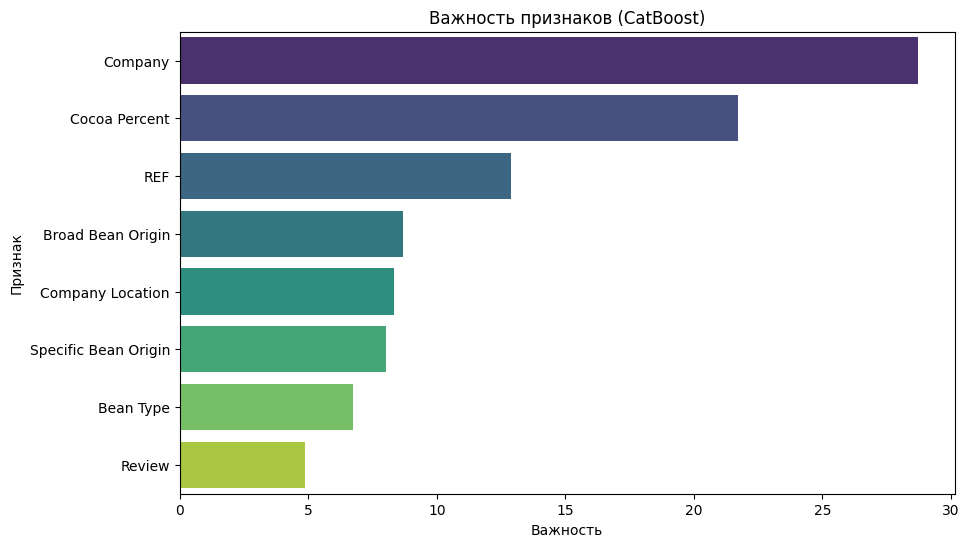

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Визуализация
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Важность признаков (CatBoost)')
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.show()

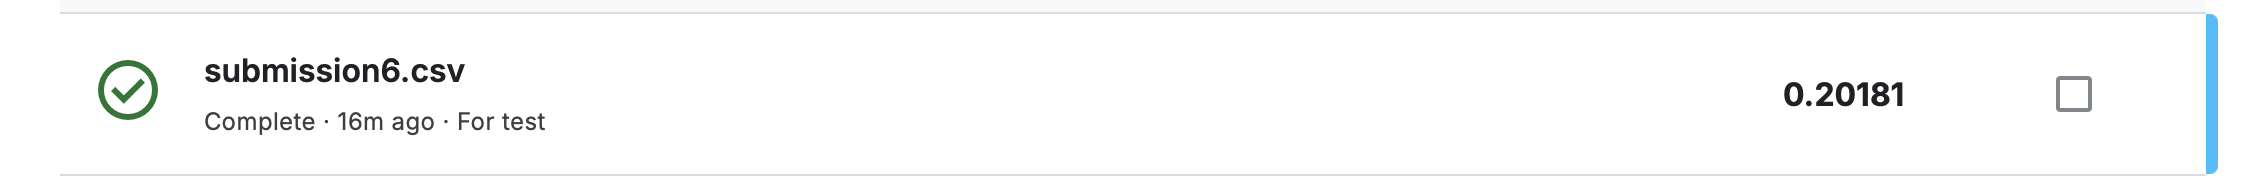